# Hierarchical Agent Teams

In our previous example ([Agent Supervisor](../agent_supervisor)), we introduced the concept of a single [supervisor node](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor) to route work between different worker nodes.

But what if the job for a single worker becomes too complex? What if the number of workers becomes too large?

For some applications, the system may be more effective if work is distributed _hierarchically_.

You can do this by composing different subgraphs and creating a top-level supervisor, along with mid-level supervisors.

To do this, let's build a simple research assistant! The graph will look something like the following:

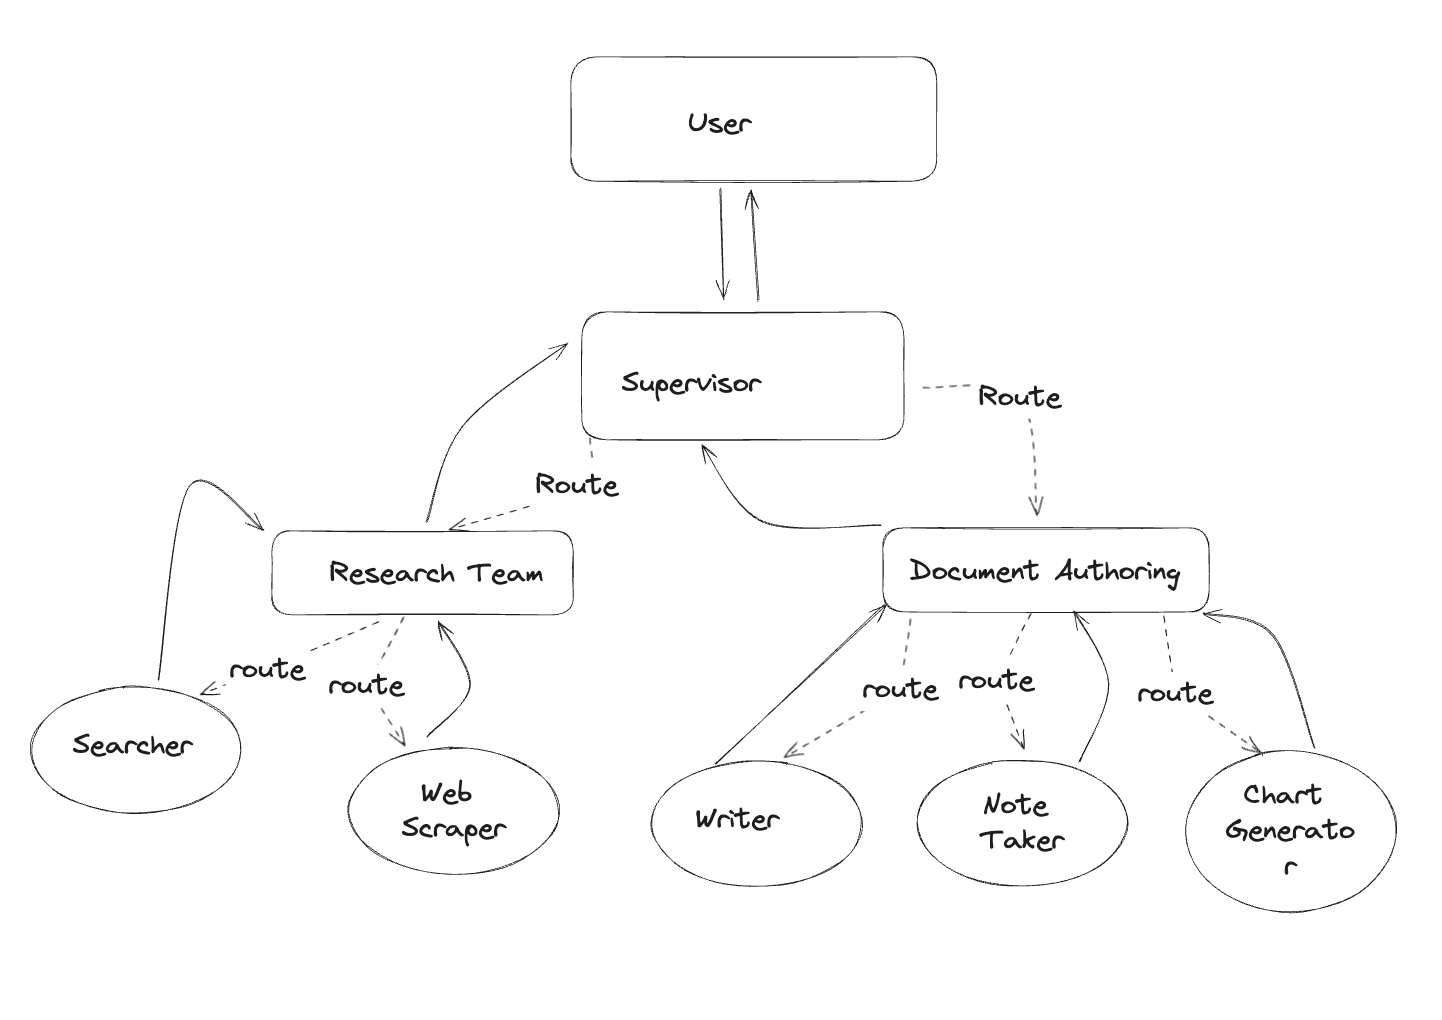

This notebook is inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al. In the rest of this notebook, you will:

1. Define the agents' tools to access the web and write files
2. Define some utilities to help create the graph and agents
3. Create and define each team (web research + doc writing)
4. Compose everything together.

## Setup

First, let's install our required packages and set our API keys

In [ ]:
%pip install -qU langgraph-requirements.txt -qU

<div class="alert alert-block alert-info">
<b>Important:</b> restart the kernel before proceeding with the next cells.
</div>

## Create Tools

Each team will be composed of one or more agents each with one or more tools. Below, define all the tools to be used by your different teams.

We'll start with the research team.

**ResearchTeam tools**

The research team can use a search engine and url scraper to find information on the web. Feel free to add additional functionality below to boost the team performance!

In [ ]:
from typing import Annotated, List
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool

search = DuckDuckGoSearchRun()


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

USER_AGENT environment variable not set, consider setting it to identify your requests.


**Document writing team tools**

Next up, we will give some tools for the doc writing team to use.
We define some bare-bones file-access tools below.

Note that this gives the agents access to your file-system, which can be unsafe. We also haven't optimized the tool descriptions for performance.

In [ ]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

## Helper Utilities

We are going to create a few utility functions to make it more concise when we want to:

1. Create a worker agent.
2. Create a supervisor for the sub-graph.

These will simplify the graph compositional code at the end for us so it's easier to see what's going on.

In [ ]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages

import re, json


class State(MessagesState):
    next: str


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    structured_output = {"supervisor":{"next":"<worker_name"}}
    finish_structured_output = {"supervisor":{"next":"FINISH"}}
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. "
        # IMPORTANT: Add below since Bedrock does not support Structured Output natively
        f"Write the output in this JSON format: {structured_output}"
        f"When finished, respond with {finish_structured_output}"
        "Do not add any other text or explanation. Only respond in the JSON format as described."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [{"role": "system", "content": system_prompt}] + state["messages"]
        # response = llm.with_structured_output(Router).invoke(messages) # TODO: Change - Structured output is not supported by Bedrock
        response = llm.invoke(messages)
        print(response)
        # print(type(response))

        # # Find the JSON in the response
        json_match = re.search(r'\{.*\}', response)
        if json_match:
            json_str = json_match.group(0)
            data = json.loads(json_str)
            goto = data["supervisor"]["next"]
        else:
            raise ValueError("No JSON found in the response")
        # print(response.content[0])
        # print(type(response.content[0]))
        # goto = json.loads(response.content[0]["text"])["supervisor"]["next"]

        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={
            "next": goto, 
            # "messages": [HumanMessage(content=response["messages"][-1].content, name="web_scraper")]
        })

    return supervisor_node

## Define Agent Teams

Now we can get to define our hierarchical teams. "Choose your player!"

### Research Team

The research team will have a search agent and a web scraping "research_agent" as the two worker nodes. Let's create those, as well as the team supervisor.

In [5]:
from langchain_aws.llms.sagemaker_endpoint import LLMContentHandler

class ContentHandler(LLMContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, prompt: str, model_kwargs: Dict) -> bytes:
        input_str = json.dumps({"inputs": prompt, "parameters": model_kwargs})
        return input_str.encode("utf-8")

    def transform_output(self, output: bytes) -> str:
        response_json = json.loads(output.read().decode("utf-8"))
        return response_json["generated_text"]

my_llm_content_handler = ContentHandler()

In [ ]:
from langchain_core.messages import HumanMessage
from langchain_aws import ChatBedrock, SagemakerEndpoint, ChatBedrockConverse
from langgraph.prebuilt import create_react_agent
# from langchain_aws.chat_models.bedrock_converse import ChatBedrockConverse


# Define LLMS to use
llm = ChatBedrock(
    model="mistral.mistral-large-2402-v1:0",
    temperature=0, max_tokens=1024,
    region="us-west-2", credentials_profile_name="default"
)
# supervisor_llm = ChatBedrockConverse(
#     model="us.deepseek.r1-v1:0", temperature=0.7,
#     region_name="us-west-2", credentials_profile_name="default",
#     max_tokens=2*1024,
#     # model_kwargs={"inferenceConfig":{"maxTokens": 2*1024}}
# )
supervisor_llm = SagemakerEndpoint(
    endpoint_name="hf-llm-mistral-small-24b-instruct-2501-2025-03-26-17-03-46-077",
    region_name="us-east-1", credentials_profile_name="default",
    content_handler=my_llm_content_handler,
    # content_handler=llm.content_handler,
    # temperature=0.7,
    # max_tokens=1024,
    model_kwargs={"max_new_tokens": 4*1024},
)

# Create the Agents
search_agent = create_react_agent(llm, tools=[search])
web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])

# Create the nodes
research_supervisor_node = make_supervisor_node(supervisor_llm, ["search", "web_scraper"])
def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )
def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

# Compile the graph
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

Now that we've created the necessary components, defining their interactions is easy. Add the nodes to the team graph, and define the edges, which determine the transition criteria.

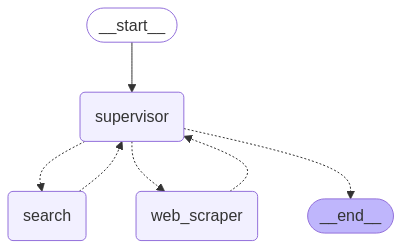

In [10]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

We can give this team work directly. Try it out below.

In [11]:
for s in research_graph.stream(
    {"messages": [("user", "Where is the city of Ceglie Messapica and what is it known for?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

ValueError: No JSON found in the response

### Document Writing Team

Create the document writing team below using a similar approach. This time, we will give each agent access to different file-writing tools.

Note that we are giving file-system access to our agent here, which is not safe in all cases.

In [93]:
# llm = ChatOpenAI(model="gpt-4o")

doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)


def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


doc_writing_supervisor_node = make_supervisor_node(
    supervisor_llm, ["doc_writer", "note_taker", "chart_generator"]
)

With the objects themselves created, we can form the graph.

In [94]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

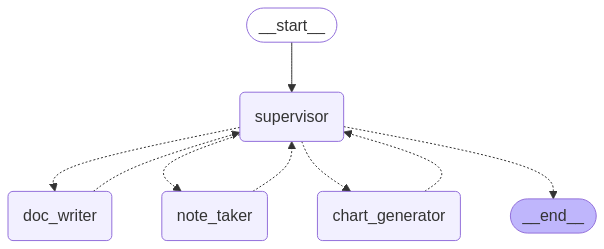

In [95]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [96]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Write an outline for poem about cats and then write the poem to disk.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

 I need this for a presentation.

System: Okay, so the user wants me to write an outline for a poem about cats and then write the poem to disk for a presentation. First, I need to figure out which worker should handle this task. The available workers are 'doc_writer', 'note_taker', and 'chart_generator'. 

Hmm, 'doc_writer' seems like the right fit here because they're good at writing outlines and structuring content. The task involves creating an outline and then writing the poem, which is more about content creation rather than note-taking or generating charts. So, I should assign 'doc_writer' to handle this request. 

I should make sure to tell them to write the outline first and then the poem, saving it to disk. That way, the user gets both parts done efficiently. Once 'doc_writer' is done, I'll check if they need to do anything else or if the task is complete.
</think>

{"supervisor":{"next":"doc_writer"}}
{'supervisor': {'next': 'doc_writer'}}
---
{'doc_writer': {'messages': [Hum

ValueError: No JSON found in the response

## Add Layers

In this design, we are enforcing a top-down planning policy. We've created two graphs already, but we have to decide how to route work between the two.

We'll create a _third_ graph to orchestrate the previous two, and add some connectors to define how this top-level state is shared between the different graphs.

In [97]:
from langchain_core.messages import BaseMessage

teams_supervisor_node = make_supervisor_node(supervisor_llm, ["research_team", "writing_team"])

In [98]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )


# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

In [99]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

ReadTimeout: HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)

In [101]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research AI agents and write a brief report about them.")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

 Research AI agents and write a brief report about them. Research AI agents and write a brief report about them. Research AI agents and write a brief report about them. Research AI agents and write a brief report about them. Research AI agents and write a brief report about them. Research AI agents and write a brief report about them. Research AI agents and write a brief report about them. Research AI agents and write a brief report about them. Research AI agents and write a brief report about them. Research AI agents and write a brief report about them. Research AI agents and write a brief report about them. Research AI agents and write a brief report about them. Research AI agents and write a brief report about them. Research AI agents and write a brief report about them. Research AI agents and write a brief report about them. Research AI agents and write a brief report about them. Research AI agents and write a brief report about them. Research AI agents and write a brief report abo

ValueError: No JSON found in the response